<a href="https://colab.research.google.com/github/conwerner/ocr_rnn/blob/main/notebooks/ocr_rnn_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/conwerner/ocr_rnn.git

Cloning into 'ocr_rnn'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 120 (delta 49), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (120/120), 88.30 KiB | 412.00 KiB/s, done.
Resolving deltas: 100% (49/49), done.


In [3]:
!pip install textdistance
!pip install shiftlab_ocr

In [33]:
import sys
sys.path.append("/content/ocr_rnn/src")
sys.path.append("/content/ocr_rnn/src/models")
import matplotlib.pyplot as plt
import torch
from config import *
from dataset import OCRdataset, Collator
from loss import CustomCTCLoss
from util import *
import model1

PREPARE SOME DEMOSTRATION DATA

In [14]:
!mkdir /content/train_images
!mkdir /content/test_images

from shiftlab_ocr import Generator
from PIL import Image

g = Generator(lang='ru')
g.upload_source('/content/ocr_rnn/notebooks/words.txt')

# train
b = g.generate_batch(10000,4,7)
f = open('/content/train_labels.txt', 'w')
for idx, b_i in enumerate(b):
  img = b_i[0].resize((256,64), Image.ANTIALIAS)
  img.save("/content/train_images/" + b_i[1] + '_' + str(idx) + '.png')
  _ = f.write(b_i[1] + '_' + str(idx) + '.png\t' + b_i[1] + '\n')
f.close()

# test
b = g.generate_batch(2000,4,7)
f = open('/content/test_labels.txt', 'w')
for idx, b_i in enumerate(b):
  img = b_i[0].resize((256,64), Image.ANTIALIAS)
  img.save("/content/test_images/" + b_i[1] + '_' + str(idx) + '.png')
  _ = f.write(b_i[1] + '_' + str(idx) + '.png\t' + b_i[1] + '\n')
f.close()

14 expressions have been udploaded


TRAIN A MODEL

In [2]:
PATH_TO_IMGDIR = "/content/train_images/"
PATH_TO_LABELS = "/content/train_labels.txt"

dataset = OCRdataset(PATH_TO_IMGDIR, PATH_TO_LABELS)
collator = Collator()
loader = torch.utils.data.DataLoader(dataset, batch_size = 128, collate_fn = collator)
model = model1.CRNN(1, 256, len(ALPHABET))
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fn = CustomCTCLoss()

In [3]:
fit(model, optimizer, loss_fn, loader, epochs = 12)

epoch | mean loss | mean cer | mean wer 
0       5.067       0.997       1.000
1       2.566       0.878       1.000
2       1.976       0.695       0.979
3       1.225       0.481       0.882
4       0.646       0.258       0.658
5       0.268       0.111       0.376
6       0.112       0.063       0.223
7       0.044       0.039       0.140
8       0.041       0.030       0.113
9       0.040       0.025       0.102
10       0.052       0.023       0.097
11       0.060       0.019       0.088


TEST

In [15]:
result = predict(model, "/content/test_images/")

100%|██████████| 2000/2000 [00:41<00:00, 47.86it/s]


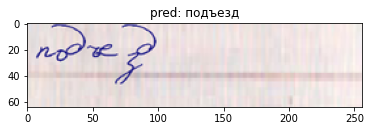

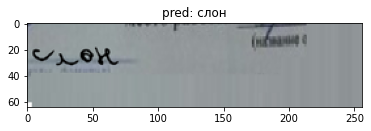

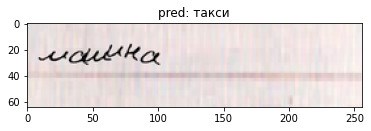

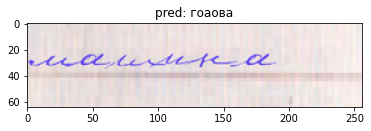

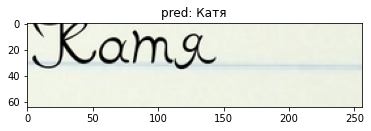

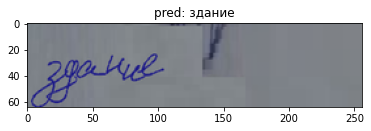

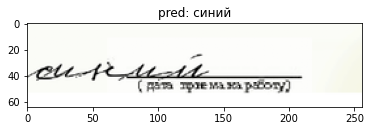

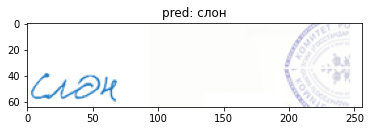

In [38]:
for image_name, pred_label in zip(result['image_name'][0:8],result['pred_label'][0:8]):
  image = plt.imread("/content/test_images/"+image_name)
  plt.title('pred: '+pred_label)
  plt.imshow(image)
  plt.show()